In [ ]:
Writing A Stacking Agreggator with Scikit-Learn

In [1]:
from __future__ import division

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing

cali_housing = fetch_california_housing()

X = cali_housing.data
y = cali_housing.target

bins = np.arange(6)
 

from sklearn.model_selection import train_test_split

binned_y = np.digitize(y, bins)

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
 
from sklearn.model_selection import GridSearchCV

X_train_prin, X_test_prin, y_train_prin, y_test_prin = train_test_split(X, y,test_size=0.2,stratify=binned_y)

binned_y_train_prin = np.digitize(y_train_prin, bins)
X_1, X_stack, y_1, y_stack = train_test_split(X_train_prin, y_train_prin,test_size=0.33,stratify=binned_y_train_prin )

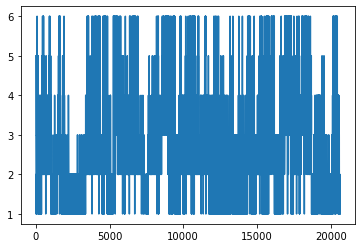

In [2]:
plt.plot(binned_y)

In [3]:
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import RandomizedSearchCV

param_dist = {
 'max_samples': [0.5,1.0],
 'max_features' : [0.5,1.0],
 'oob_score' : [True, False],
 'base_estimator__n_neighbors': [3,5],
 'n_estimators': [100]
 }

single_estimator = KNeighborsRegressor()
ensemble_estimator = BaggingRegressor(base_estimator = single_estimator)

pre_gs_inst_bag = RandomizedSearchCV(ensemble_estimator,
 param_distributions = param_dist,
 cv=3,
 n_iter = 5,
 n_jobs=-1)

pre_gs_inst_bag.fit(X_1, y_1)

RandomizedSearchCV(cv=3,
                   estimator=BaggingRegressor(base_estimator=KNeighborsRegressor()),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'base_estimator__n_neighbors': [3, 5],
                                        'max_features': [0.5, 1.0],
                                        'max_samples': [0.5, 1.0],
                                        'n_estimators': [100],
                                        'oob_score': [True, False]})

In [4]:
rs_bag = BaggingRegressor(**{'max_features': 0.5,
 'max_samples': 0.5,
 'n_estimators': 3000,
 'oob_score': False, 
 'base_estimator': KNeighborsRegressor(n_neighbors=3)})

rs_bag.fit(X_1, y_1)

BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=3),
                 max_features=0.5, max_samples=0.5, n_estimators=3000)

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'max_features' : ['log2',0.4,0.5,0.6,1.0],
 'max_depth' : [2,3, 4, 5,6, 7, 10],
 'min_samples_leaf' : [1,2, 3, 4, 5, 10],
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.25,0.275,0.3,0.325],
 'loss' : ['ls','huber']
 }
pre_gs_inst = RandomizedSearchCV(GradientBoostingRegressor(warm_start=True),param_distributions = param_dist,
 cv=3,
 n_iter = 30, n_jobs=-1)
pre_gs_inst.fit(X_1, y_1)

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(warm_start=True),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.25,
                                                          0.275, 0.3, 0.325],
                                        'loss': ['ls', 'huber'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 10],
                                        'max_features': ['log2', 0.4, 0.5, 0.6,
                                                         1.0],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                                        'n_estimators': [50, 100]})

In [6]:
gbt_inst = GradientBoostingRegressor(**{'learning_rate': 0.05,
 'loss': 'huber',
 'max_depth': 10,
 'max_features': 0.4,
 'min_samples_leaf': 5,
 'n_estimators': 3000,
 'warm_start': True}).fit(X_1, y_1)

In [7]:
y_pred_bag = rs_bag.predict(X_stack)
y_pred_gbt = gbt_inst.predict(X_stack)

In [8]:
from sklearn.metrics import r2_score, mean_absolute_error

print("R-squared",r2_score(y_stack, y_pred_bag))
print("MAE : ",mean_absolute_error(y_stack, y_pred_bag))
print("MAPE : ",(np.abs(y_stack- y_pred_bag)/y_stack).mean())

R-squared 0.5288971637150538
MAE :  0.6052133361579095
MAPE :  0.4037520575555524


In [10]:
from sklearn.metrics import r2_score, mean_absolute_error

print("R-squared",r2_score(y_stack, y_pred_gbt))
print("MAE : ",mean_absolute_error(y_stack, y_pred_gbt))
print("MAPE : ",(np.abs(y_stack- y_pred_gbt)/y_stack).mean())

R-squared 0.839506174901222
MAE :  0.29859060520433917
MAPE :  0.16766680252841132


In [11]:
y_pred_bag = pre_gs_inst_bag.predict(X_stack)
y_pred_gbt = gbt_inst.predict(X_stack)

preds_df = pd.DataFrame(columns = ['bag', 'gbt'])

preds_df['bag'] = y_pred_bag
preds_df['gbt'] = y_pred_gbt


preds_df

,bag,gbt
0,2.209644,2.192007
1,3.696396,5.117302
2,1.909518,1.515199
3,2.609009,2.924848
4,1.935112,2.981249
...,...,...
5444,1.849006,2.248410
5445,2.029978,1.821124
5446,1.988274,1.634483
5447,2.059390,2.067197


In [12]:
preds_df.corr()

,bag,gbt
bag,1.000000,0.889927
gbt,0.889927,1.000000


In [13]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'max_features' : ['sqrt','log2',1.0],
 'min_samples_leaf' : [1, 2, 3, 7, 11],
 'n_estimators': [50, 100],
 'oob_score': [True, False]}

pre_gs_inst = RandomizedSearchCV(ExtraTreesRegressor(warm_start=True,bootstrap=True),
 param_distributions = param_dist,
 cv=3,
 n_iter = 15)

pre_gs_inst.fit(preds_df.values, y_stack)

RandomizedSearchCV(cv=3,
                   estimator=ExtraTreesRegressor(bootstrap=True,
                                                 warm_start=True),
                   n_iter=15,
                   param_distributions={'max_features': ['sqrt', 'log2', 1.0],
                                        'min_samples_leaf': [1, 2, 3, 7, 11],
                                        'n_estimators': [50, 100],
                                        'oob_score': [True, False]})

In [14]:
import copy
 
param_dict = copy.deepcopy(pre_gs_inst.best_params_)
 
param_dict['n_estimators'] = 2000
param_dict['warm_start'] = True
param_dict['bootstrap'] = True
param_dict['n_jobs'] = -1
 
param_dict

{'oob_score': True,
 'n_estimators': 2000,
 'min_samples_leaf': 7,
 'max_features': 1.0,
 'warm_start': True,
 'bootstrap': True,
 'n_jobs': -1}

In [15]:
final_etr = ExtraTreesRegressor(**param_dict)
final_etr.fit(preds_df.values, y_stack)

ExtraTreesRegressor(bootstrap=True, max_features=1.0, min_samples_leaf=7,
                    n_estimators=2000, n_jobs=-1, oob_score=True,
                    warm_start=True)

In [17]:
def handle_X_set(X_train_set):
    y_pred_bag = rs_bag.predict(X_train_set)
    y_pred_gbt = gbt_inst.predict(X_train_set)
    preds_df = pd.DataFrame(columns = ['bag', 'gbt'])

    preds_df['bag'] = y_pred_bag
    preds_df['gbt'] = y_pred_gbt
 
    return preds_df.values

def predict_from_X_set(X_train_set):
    return final_etr.predict(handle_X_set(X_train_set)) 

y_pred = predict_from_X_set(X_test_prin)

In [19]:
# It is possible to increase score by including the data columns alongside the stacker predictions
from sklearn.metrics import r2_score, mean_absolute_error

print("R-squared",r2_score(y_test_prin, y_pred))
print("MAE : ",mean_absolute_error(y_test_prin, y_pred))
print("MAPE : ",(np.abs(y_test_prin- y_pred)/y_test_prin).mean())

R-squared 0.8523162732687882
MAE :  0.29330243499661973
MAPE :  0.1645783164258295
